In [3]:
%pip install humanfriendly

/home/lukas/school/tree-statistics/.venv/bin/python3: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
os.environ['MEMORY_LIMIT'] = '10GB'

In [2]:
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists, join
from io import StringIO  
from datetime import timedelta

In [66]:
ALGORITHMS = {
    'structural': 'Structural',
    'structural-variant': 'Splitted Structural',
    'sed': 'Sed',
    'lblint': 'Lbl-Int',
    'bib': 'Binary branch',
    'sedindex': 'Sed Index',
    'lblindex': 'Lbl-Int Index',
    'structuralindex': 'Structural Index',
}

datasets = ('dblp', 'ptb', 'python', 'sentiment', 'swissprot', 'treefam')

In [6]:
ALGORITHMS_ENUM_NAMES = {
    'structural': 'Structural',
    'structural-variant': 'StructuralVariant',
    'sed': 'Sed',
    'lblint': 'Lblint',
    'bib': 'Bib'
}

In [7]:
BASEPATH = 'resources/results/'
def load_dataset(dataset: str, threshold: int):
    algorithm_times = dict()
    for alg in ALGORITHMS.keys():
        join_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(join_times_path):
            print(alg, 'is not computed for', dataset, f'{join_times_path} skipping')
            continue
        df = pd.read_csv(join_times_path, names=["time"])
        
        candidate_eval_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(candidate_eval_times_path):
            print(alg, 'is not computed for', dataset, f'{candidate_eval_times_path} skipping')
            continue
        lb_df = pd.read_csv(candidate_eval_times_path, names=["query_filter_time_us"])
        
        with open(join(BASEPATH, dataset, str(threshold), f'{dataset}-{alg}-precision.txt')) as f:
            selectivity_line = f.readline()
            rest = f.read()
            
            if not selectivity_line.startswith('Mean selectivi'):
                rest = selectivity_line + rest

        # sel = selectivity_line.split(':')[1]
        # sel = float(sel.rstrip('%\n'))
        # print(sel)
        # seldf = pd.DataFrame.from_dict({'selectivity': [sel] })
        precision = pd.read_csv(StringIO(rest), delimiter=';')
        algorithm_times[alg] = [df, precision, lb_df]
    return algorithm_times

In [8]:
# tested_values= [('swissprot', 20), ('bolzano', 20), ('python', 30), ('sentiment', 10), ('ptb', 10), ('treefam', 15), ('DBLP', 6)]
tested_values= [('bolzano', 6), ('sentiment', 10), ('ptb', 15), ('treefam', 60), ('python', 15), ('dblp', 6)]

In [7]:
dataframes = dict()
for ds, t in tested_values:
    try:
        dataframes[ds] = load_dataset(ds, t)
    except Exception:
        print('Failed getting results from ', ds)

In [8]:
selectivities = [ (ds, float(dataframes[ds]['sed'][1]['Mean Selectivity'][0].rstrip('%') ), t) for ds, t in tested_values ]
selectivity_df = pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])
selectivity_df

,Dataset,Mean query selectivity %,Threshold
0,bolzano,0.449224,6
1,sentiment,0.342106,10
2,ptb,0.076641,15
3,treefam,0.132683,60
4,python,0.404772,15
5,dblp,0.000270,6


In [14]:
def load_stats(dataset: str):
    ds_path = join('./resources/statistics', dataset.lower())
    path = join(ds_path, 'collection.csv')
    df = pd.read_csv(path)
    depths = pd.read_csv(join(ds_path, 'depths.csv'), names=['root-leaf-distance'], header=None)
    degrees = pd.read_csv(join(ds_path, 'degrees.csv'), names=['degree'], header=None)

    df.insert(0, 'Dataset', [dataset.capitalize()], True)
    df.insert(6, 'Mean node degree', [degrees['degree'].mean()])
    df.insert(6, 'Min node degree', [degrees['degree'].min()])
    df.insert(6, 'Max node degree', [degrees['degree'].max()])
    df.insert(9, 'Min tree height', [depths['root-leaf-distance'].min()])
    df.insert(9, 'Max tree height', [depths['root-leaf-distance'].max()])
    df.insert(6, 'Tree/Label ratio', df['tree_count'] / df['distinct_labels'])
    df.insert(6, 'Tree size/Label ratio', (df['avg_tree'] / df['distinct_labels']) * 100)
    df.insert(9, 'Mean tree height (root to leaf distance)', [depths['root-leaf-distance'].mean()])
    return (df, depths, degrees)

df = pd.DataFrame()
for i, (ds, _) in enumerate(tested_values):
    row = int(i >= 4)
    col = i % 4
    loaded, dep, deg = load_stats(ds)
    df = pd.concat([df, loaded])

pd.set_option('display.precision', 3)

df.reset_index()
df = df.rename(columns={
    'mint': 'Min tree size',
    'maxt': 'Max tree size',
    'avgt': 'Average tree size',
    'distinct_labels': 'No. of distinct labels',
    'trees': 'No. of trees in dataset',
})
display(df)

,Dataset,min_tree,max_tree,avg_tree,tree_count,No. of distinct labels,Tree size/Label ratio,Tree/Label ratio,Max node degree,Mean tree height (root to leaf distance),Min node degree,Mean node degree,Max tree height,Min tree height
0,Bolzano,2,2195,179,299,593,30.185,0.504,198,2.841,1,1.989,3,1
0,Sentiment,3,103,37,9645,19470,0.190,0.495,3,7.015,1,1.946,29,1
0,Ptb,3,711,72,3832,13080,0.550,0.293,33,6.874,1,1.972,29,2
0,Treefam,63,15065,2666,5000,1276005,0.209,0.004,8,16.709,1,1.999,54,2
0,Python,1,43270,948,49977,1478718,0.064,0.034,13974,8.411,0,1.998,122,0
0,Dblp,9,1703,26,150000,992865,0.003,0.151,430,2.018,1,1.923,5,1


,Dataset,min_tree,max_tree,avg_tree,tree_count,No. of distinct labels,Max node degree,Min node degree,Mean node degree,Mean tree height (root to leaf distance),Max tree height,Min tree height
0,Bolzano,2,2195,179,299,593,198,1,1.989,2.841,3,1
0,Sentiment,3,103,37,9645,19470,3,1,1.946,7.015,29,1
0,Ptb,3,711,72,3832,13080,33,1,1.972,6.874,29,2
0,Treefam,63,15065,2666,5000,1276005,8,1,1.999,16.709,54,2
0,Python,1,43270,948,49977,1478718,13974,0,1.998,8.411,122,0
0,Dblp,9,1703,26,150000,992865,430,1,1.923,2.018,5,1


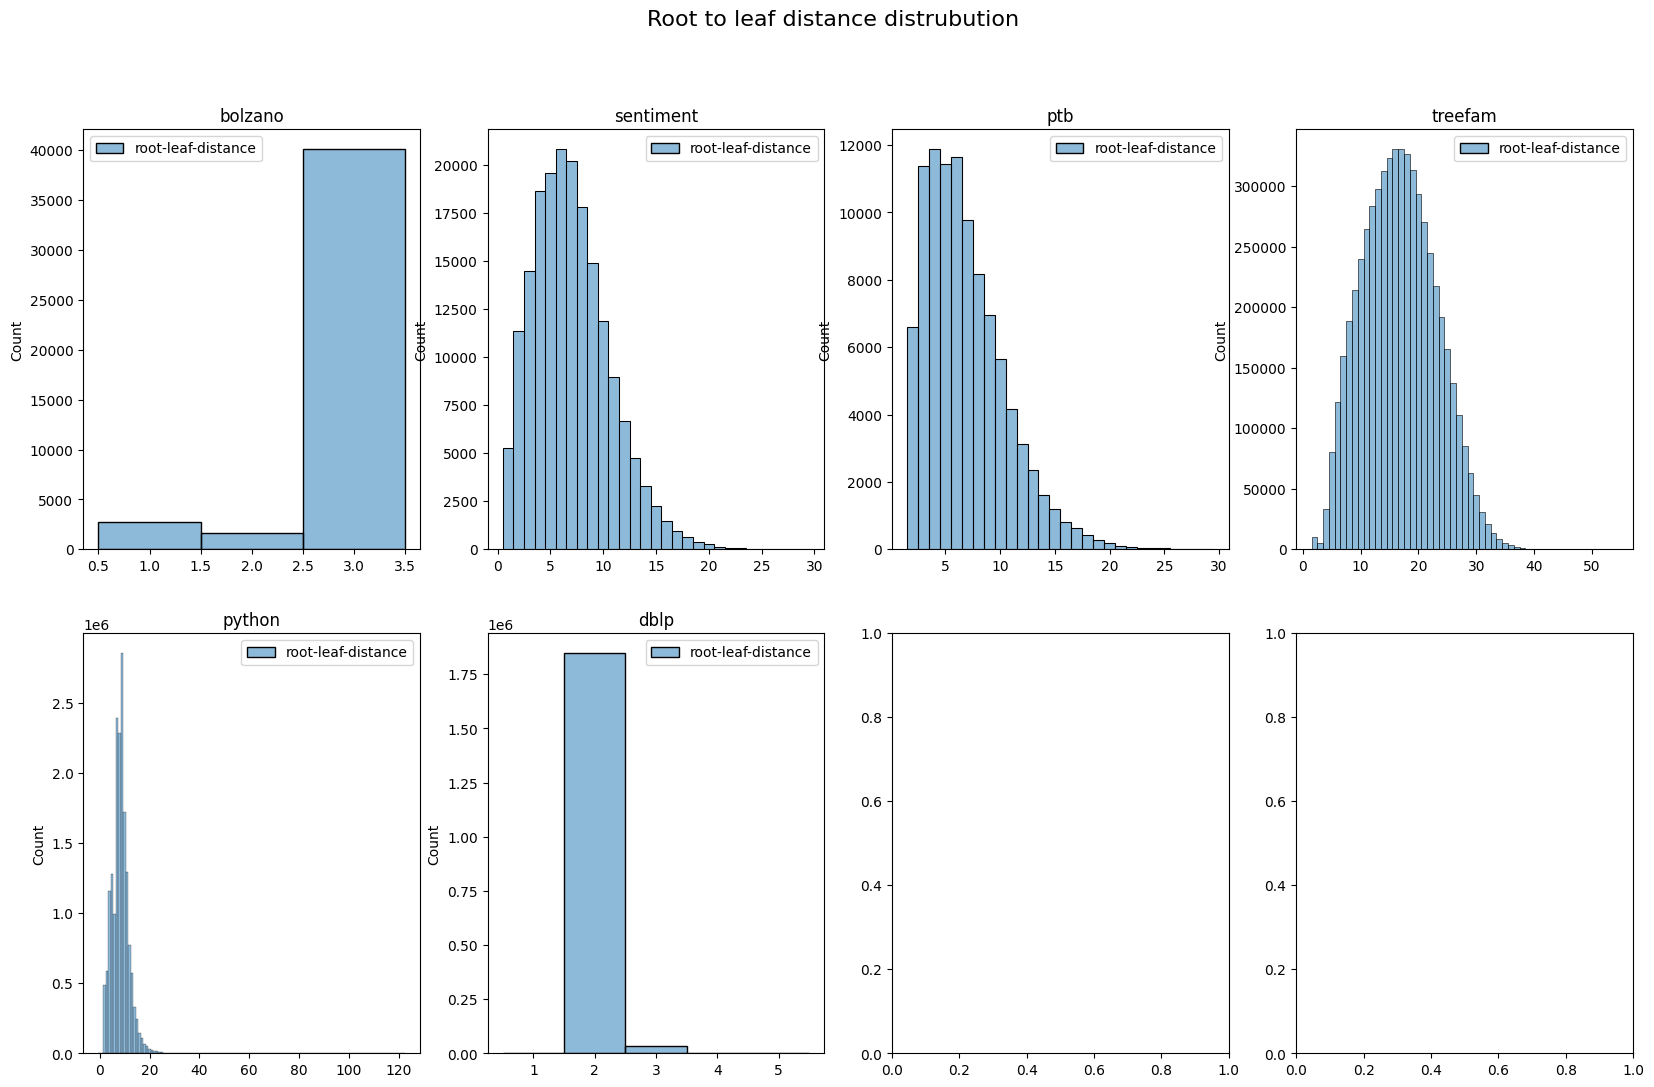

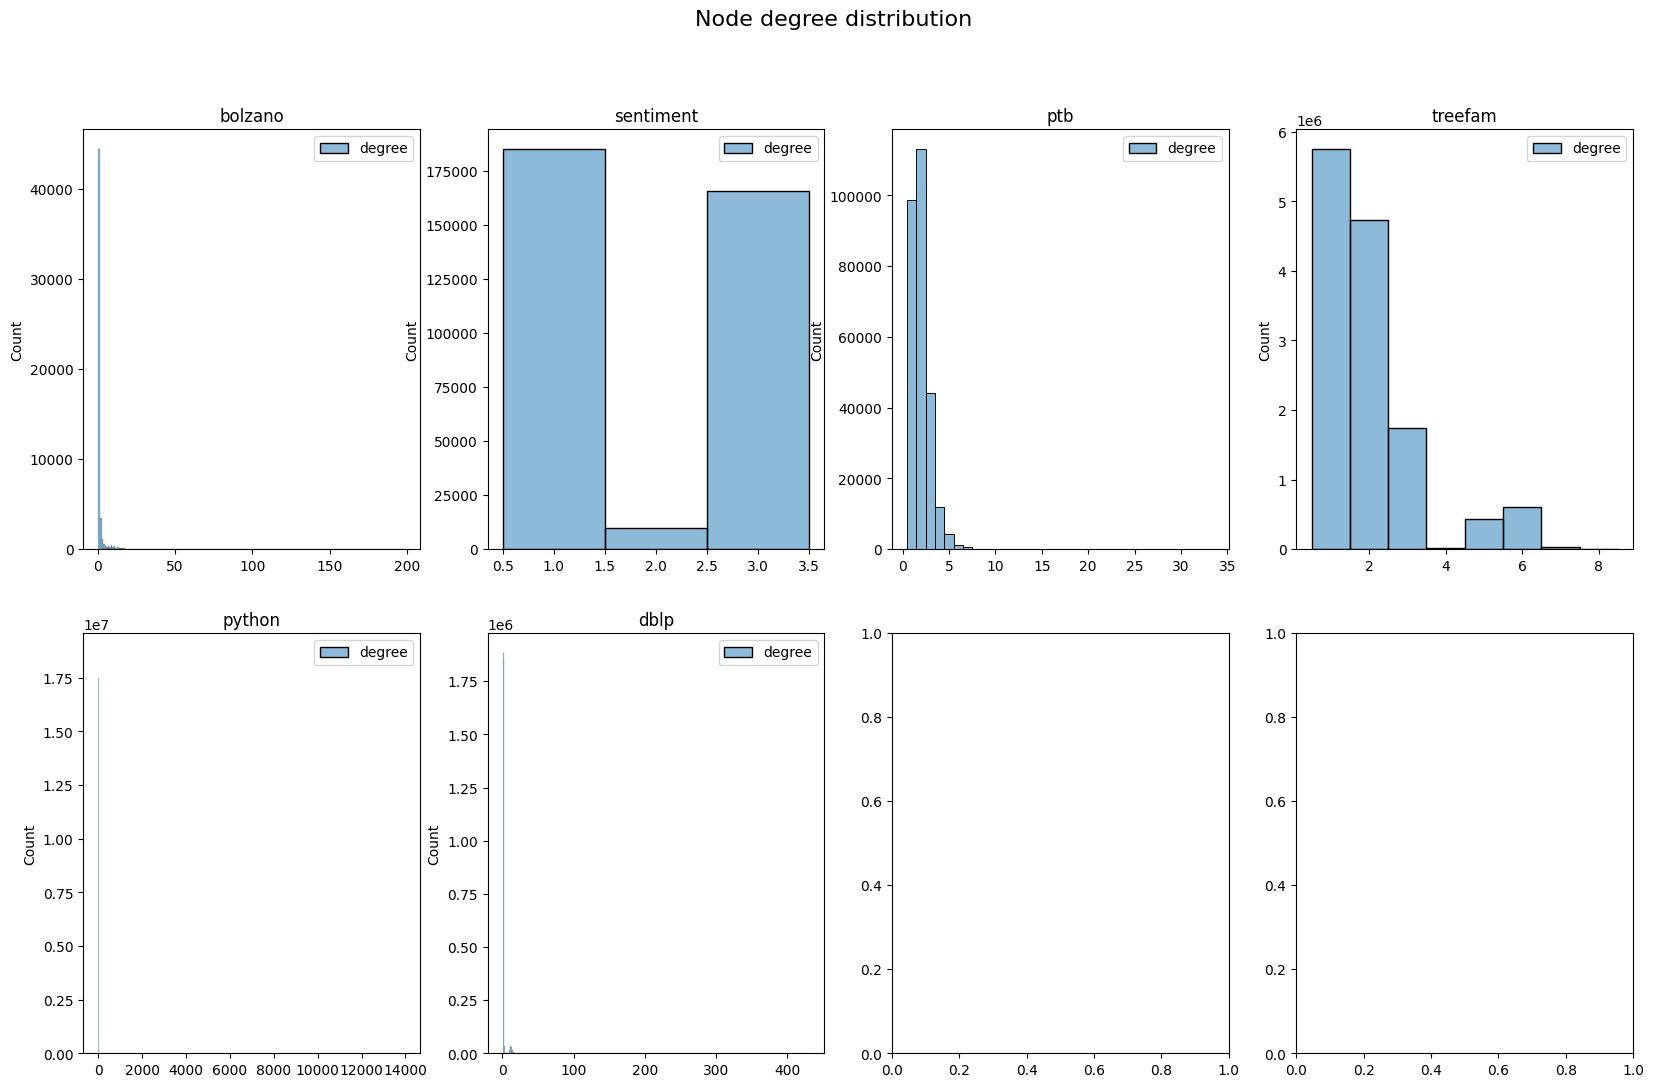

In [9]:
def load_stats(dataset: str):
    ds_path = join('./resources/statistics', dataset.lower())
    path = join(ds_path, 'collection.csv')
    df = pd.read_csv(path)
    depths = pd.read_csv(join(ds_path, 'depths.csv'), names=['root-leaf-distance'], header=None)
    degrees = pd.read_csv(join(ds_path, 'degrees.csv'), names=['degree'], header=None)

    df.insert(0, 'Dataset', [dataset.capitalize()], True)
    df.insert(6, 'Mean node degree', [degrees['degree'].mean()])
    df.insert(6, 'Min node degree', [degrees['degree'].min()])
    df.insert(6, 'Max node degree', [degrees['degree'].max()])
    df.insert(9, 'Min tree height', [depths['root-leaf-distance'].min()])
    df.insert(9, 'Max tree height', [depths['root-leaf-distance'].max()])
    df.insert(9, 'Mean tree height (root to leaf distance)', [depths['root-leaf-distance'].mean()])
    return (df, depths, degrees)

f, axes = plt.subplots(2, 4, figsize=(20, 12))
f2, axes2 = plt.subplots(2, 4, figsize=(20, 12))
f.suptitle('Root to leaf distance distrubution', fontsize=16)
f2.suptitle('Node degree distribution', fontsize=16)
df = pd.DataFrame()
for i, (ds, _) in enumerate(tested_values):
    row = int(i >= 4)
    col = i % 4
    loaded, dep, deg = load_stats(ds)
    hp = sns.histplot(data=dep, ax=axes[row][col], discrete=True)
    hp.set(title=ds)
    hp2 = sns.histplot(data=deg, ax=axes2[row][col], discrete=True)
    hp2.set(title=ds)
    df = pd.concat([df, loaded])

pd.set_option('display.precision', 3)

df.reset_index()
df = df.rename(columns={
    'mint': 'Min tree size',
    'maxt': 'Max tree size',
    'avgt': 'Average tree size',
    'distinct_labels': 'No. of distinct labels',
    'trees': 'No. of trees in dataset',
})
display(df)

In [8]:
def load_verification_times(dataset: str, threshold: int):
    runtime_df, absolute_df, lb_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    empty = True
    for lb_method in ALGORITHMS.keys():
        # print(lb_method)
        apted_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-apted-verification-times-ns.csv')
        topdiff_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-topdiff-verification-times-ns.csv')
    
        apted_df = pd.read_csv(apted_times, skiprows=2, names=["apted-verification-nanos"])
        topdiff_df = pd.read_csv(topdiff_times, skiprows=2, names=["topdiff-verification-nanos"])
        df = apted_df.join(topdiff_df).join(dataframes[dataset][lb_method][2])
        df['query_filter_time_nanos'] = df['query_filter_time_us'] * 1000
        
        df['lb_method'] = ALGORITHMS[lb_method]

        # runtime is in MS
        rtdf = pd.DataFrame.from_records([
            (
                (df['apted-verification-nanos'].sum() / 1000 / 1000),
                (df['topdiff-verification-nanos'].sum() / 1000 / 1000),
                df['query_filter_time_us'].sum() / 1000,
                (df['apted-verification-nanos'].sum() / 1000 / 1000) + df['query_filter_time_us'].sum() / 1000,
                (df['topdiff-verification-nanos'].sum() / 1000 / 1000) + df['query_filter_time_us'].sum() / 1000,
                lb_method
            )
        ] , columns=['apted-candidates', 'topdiff-candidates', 'lb-runtime', 'apted-runtime', 'topdiff-runtime', 'lb_method'])
        
        v_vars=['apted-runtime', 'topdiff-runtime']
        
        # total_runtime = df.melt(
        #     value_vars=v_vars, id_vars=['lb_method'], var_name='verification-method', value_name='runtime'
        # )
        
        melted_absolute = df.melt(
            value_vars=['apted-verification-nanos', 'topdiff-verification-nanos'], id_vars=['lb_method'], var_name='verification-method', value_name='nanos'
        )

        melted_lb = df.melt(value_vars=['query_filter_time_us'], id_vars=['lb_method'], value_name='lb_time')
        
        if empty:
            runtime_df = rtdf
            absolute_df = melted_absolute
            lb_df = melted_lb
            empty = False
        else:
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            runtime_df = pd.concat([runtime_df, rtdf], ignore_index=True)
            absolute_df = pd.concat([absolute_df, melted_absolute], ignore_index=True)
            lb_df = pd.concat([lb_df, melted_lb], ignore_index=True)
        # df['lb-apted-perc'] = 100 - df['apted-perc']
        # df['lb-topdiff-perc'] =  100 - df['topdiff-perc'] 
    
    return runtime_df, absolute_df, lb_df
    ...

In [9]:
runtime, melted_absolute, lb_df = load_verification_times('bolzano', 6)

In [120]:
humanfriendly.format_timespan(timedelta(milliseconds=3810159.25010))

'1 hour, 3 minutes and 30.16 seconds'

# Verification time (TED time) % of complete LB + verification time

The lower the verification time %, the faster the LB method was in comparison to verification by using
either exact TED (APTED) or using bounded-TED (topdiff)

In [17]:
verification_times = []
for i, (ds, t) in enumerate(tested_values):
    print('Loading ', ds, ', t =', t, i)
    verification_times.append(load_verification_times(ds, t))

Loading  bolzano , t = 6 0
Loading  sentiment , t = 10 1
Loading  ptb , t = 15 2
Loading  treefam , t = 60 3
Loading  python , t = 15 4
Loading  dblp , t = 6 5


In [11]:
new_labels = ["Structural", "Splitted structural", "String LB", "Label intersection", "Binary branch"]
# new_labels = ["Structural", "Splitted structural", "String LB", "Label intersection"]

In [23]:
runtime, melted_absolute, lb_df = verification_times[-1]

display(runtime)

rtmt = runtime.melt(value_vars=['apted-runtime', 'topdiff-runtime'], id_vars=['lb_method'], var_name='verification method', value_name='runtime')
grouped = rtmt.groupby(['lb_method', 'verification method']).sum()
upper_bound = grouped.loc[('structural-variant', 'apted-runtime')]['runtime'] + grouped.loc[('sed', 'apted-runtime')]['runtime']
grouped
# upper_bound = grouped['structural-variant'] + grouped['


,apted-candidates,topdiff-candidates,lb-runtime,apted-runtime,topdiff-runtime,lb_method
0,1635.589122,465.959918,5052413.697,5.054049e+06,5.052880e+06,structural
1,1632.496083,469.015633,8205720.433,8.207353e+06,8.206189e+06,structural-variant
2,1629.704043,471.774304,1694818.985,1.696449e+06,1.695291e+06,sed
3,1774.670993,494.007849,2060990.534,2.062765e+06,2.061485e+06,lblint
4,390935.751614,99227.057364,813437.629,1.204373e+06,9.126647e+05,bib


runtime
lb_method          verification method              
bib                apted-runtime        1.204373e+06
                   topdiff-runtime      9.126647e+05
lblint             apted-runtime        2.062765e+06
                   topdiff-runtime      2.061485e+06
sed                apted-runtime        1.696449e+06
                   topdiff-runtime      1.695291e+06
structural         apted-runtime        5.054049e+06
                   topdiff-runtime      5.052880e+06
structural-variant apted-runtime        8.207353e+06
                   topdiff-runtime      8.206189e+06

Loading  dblp , t = 6 0


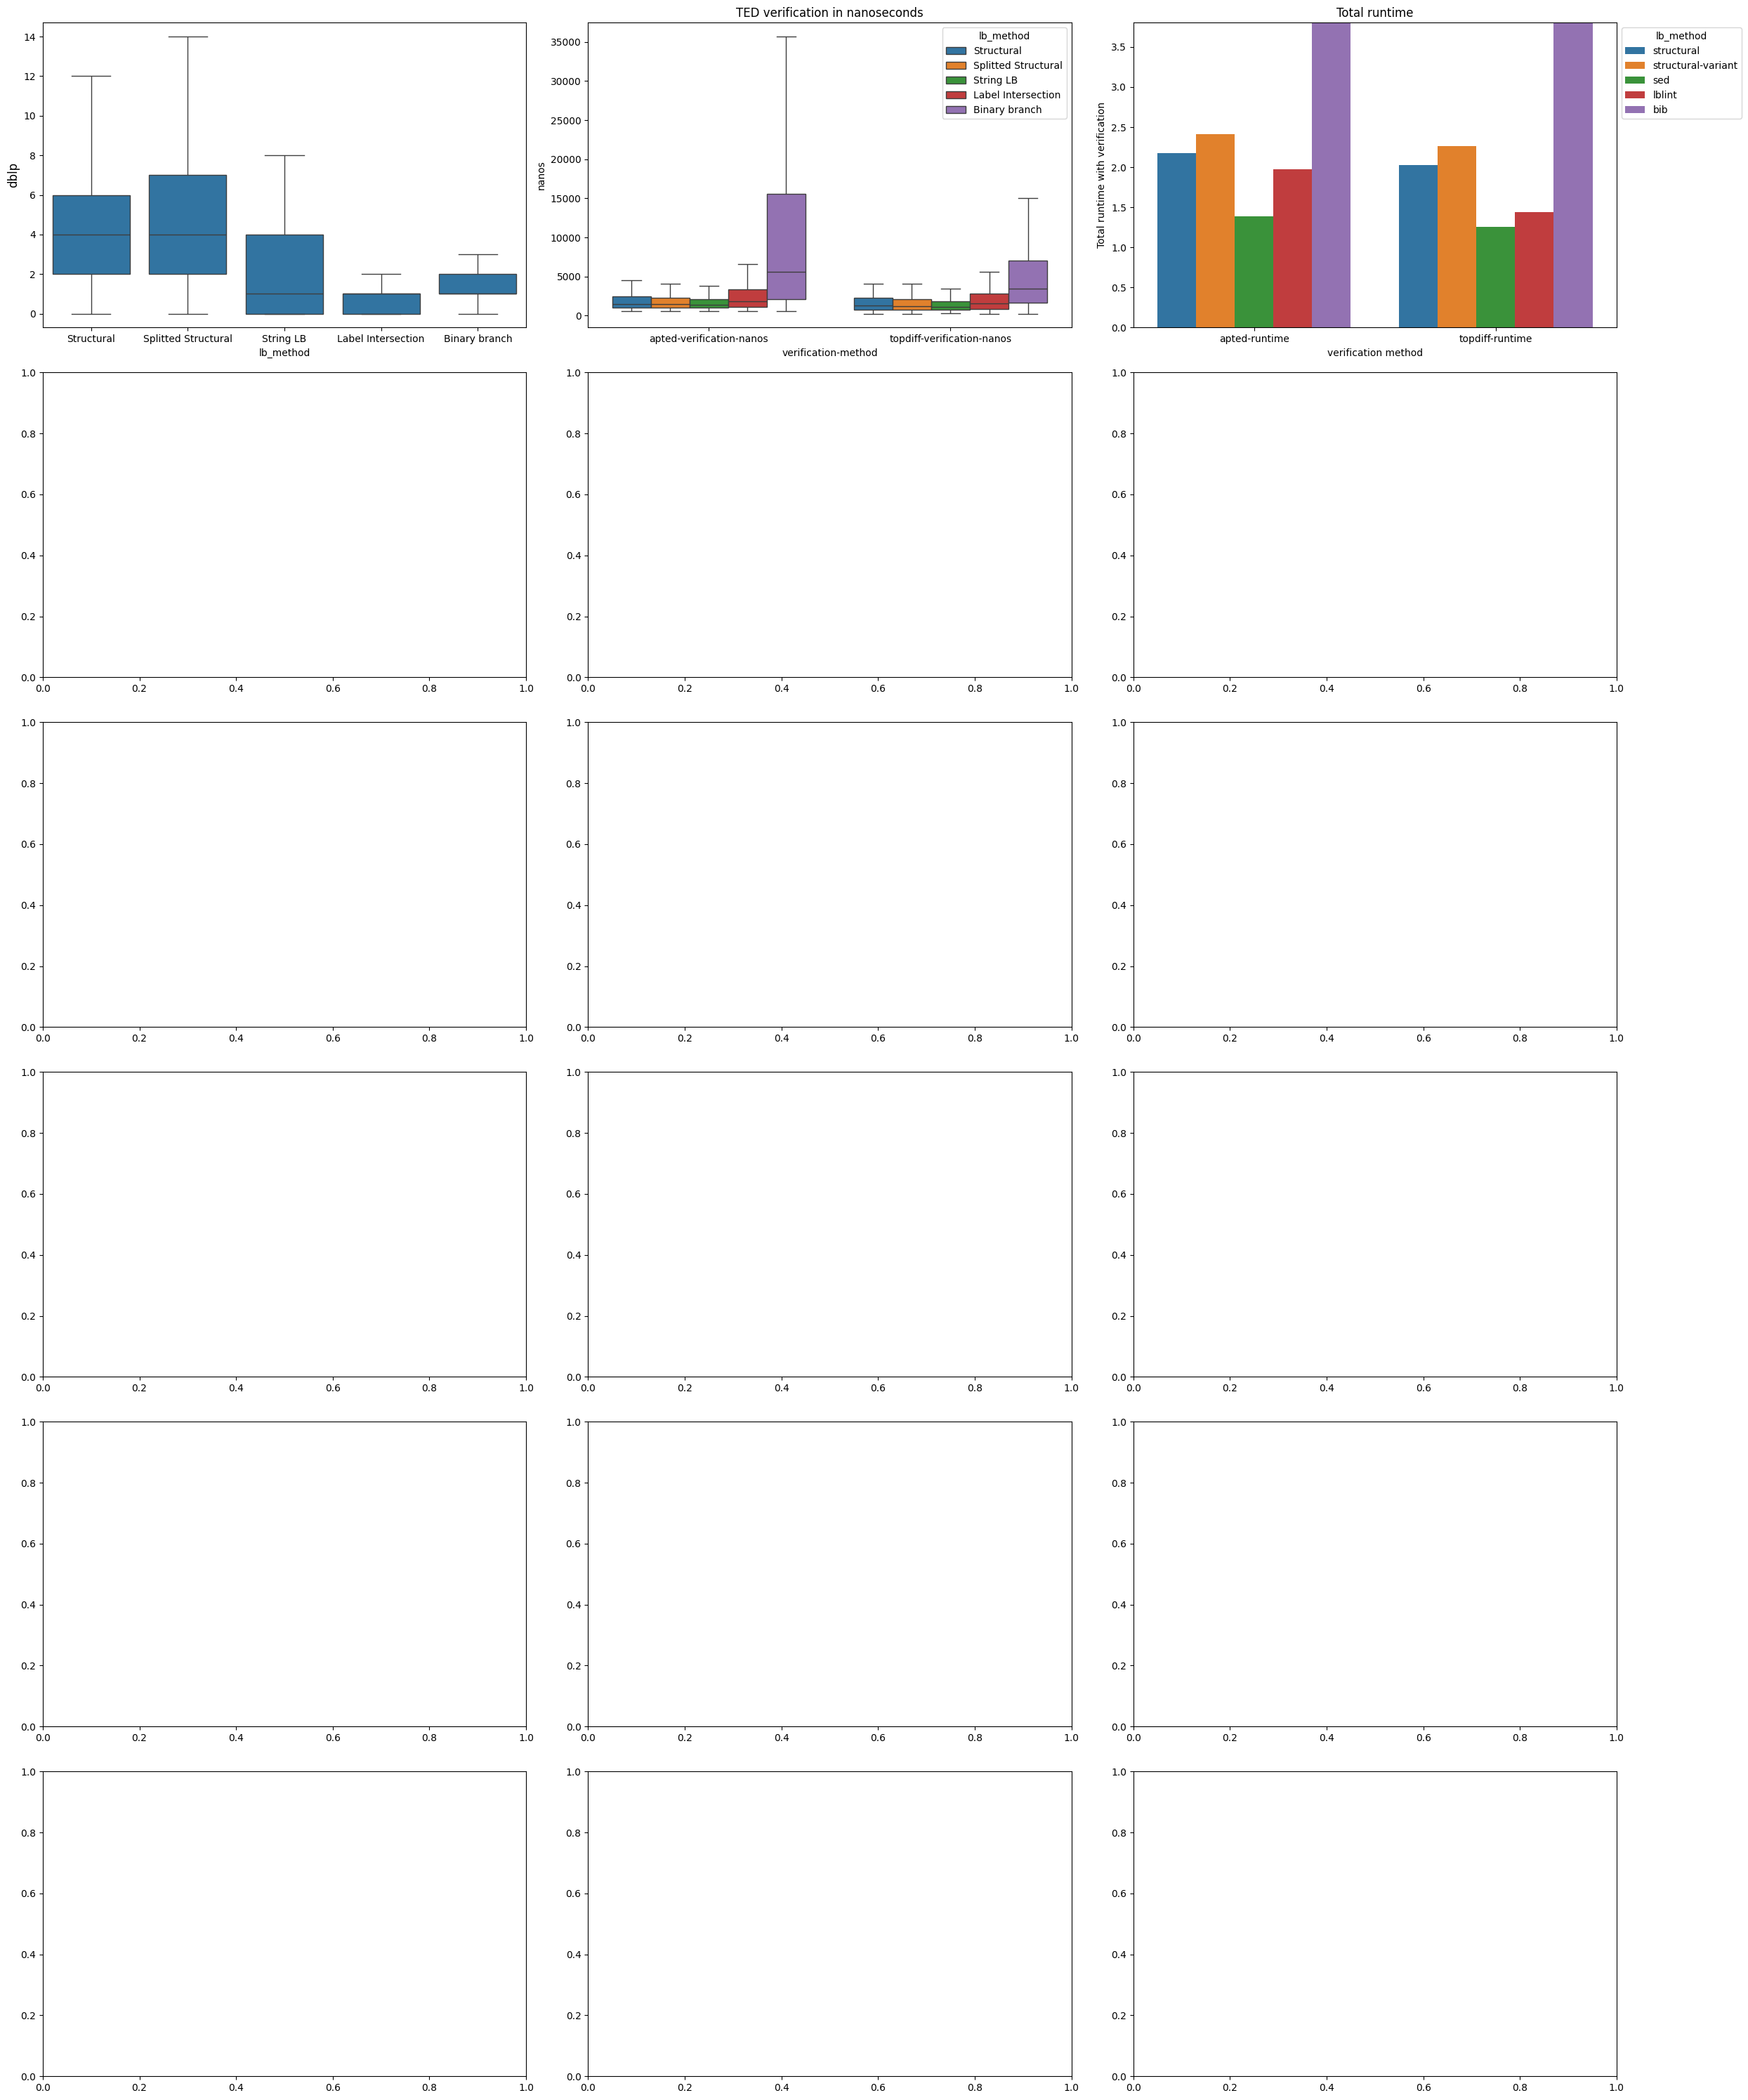

In [26]:
len_tested = len(tested_values)
fig, axes = plt.subplots(len_tested, 3, figsize=(25, 30))
# http://localhost:8888/lab/tree/TED-viz.ipynb#Verification-time-(TED-time)-%-of-complete-LB-+-verification-time
for i, (ds, t) in enumerate(tested_values[-1:]):
    print('Loading ', ds, ', t =', t, i)
    ###### Filter runtime #########
    runtime, melted_absolute, lb_df = verification_times[i]
    ofix, oax = plt.subplots(figsize=(8, 6))
    sns.boxplot(data=lb_df, x='lb_method', y='lb_time', showfliers = False, ax=axes[i, 0])
    
    filter_boxplot = sns.boxplot(data=lb_df, x='lb_method', y='lb_time', showfliers = False, ax=oax)
    oax.set_title('LB filter time')
    oax.set_ylabel('Microseconds')
    oax.set_xlabel('LB filter')
    ofix.savefig(f"resources/plots/{ds}-filter-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)
    ofix, oax = plt.subplots(figsize=(10, 6))


    ###### Verification times #########
    # axes[i, 0].set_title('LB comp time in nanoseconds')
    sns.boxplot(data=melted_absolute, x='verification-method', hue='lb_method', y='nanos', showfliers = False, ax=axes[i, 1])
    verif_plot = sns.boxplot(data=melted_absolute, x='verification-method', hue='lb_method', y='nanos', showfliers = False, ax=oax)
    sns.move_legend(oax, 'best', title='LB method', labels=new_labels)
    axes[i, 1].set_title('TED verification in nanoseconds')
    oax.set_title('TED verification in nanoseconds')
    oax.set_ylabel('Nanoseconds')
    oax.set_xlabel('Verification method')
    # sns.move_legend(axes[i, 1], "upper left", bbox_to_anchor=(1, 1))
    # sns.move_legend(oax, "upper left", bbox_to_anchor=(1, 1))
    
    ofix.savefig(f"resources/plots/{ds}-verification-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)

    ###### Overall runtime #########
    ofix, oax = plt.subplots(figsize=(10, 6))
    rtmt = runtime.melt(value_vars=['apted-runtime', 'topdiff-runtime'], id_vars=['lb_method'], var_name='verification method', value_name='runtime')

    grouped = rtmt.groupby(['lb_method', 'verification method']).sum()
    upper_bound = grouped.loc[('structural-variant', 'apted-runtime')]['runtime'] + grouped.loc[('sed', 'apted-runtime')]['runtime']
    
    sns.barplot(data=rtmt, x='verification method', hue='lb_method', y='runtime', ax=axes[i, 2])
    axes[i, 2].set_ylim(0, upper_bound)
    runtime_fig = sns.barplot(data=rtmt, x='verification method', hue='lb_method', y='runtime', ax=oax)
    sns.move_legend(axes[i, 2], "upper left", bbox_to_anchor=(1, 1))
    axes[i, 2].set_title('Total runtime')
    axes[i, 2].set_ylabel('Total runtime with verification')

    # axes[i, 2].bar_label(axes[i, 2].containers[-1], label_type='center', rotation=90, color='white')

    # sns.move_legend(oax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(oax, 'best', title='LB method', labels=new_labels)
    oax.set_ylim(0, upper_bound)
    oax.set_title('Total runtime')
    oax.set_ylabel('Nanoseconds')
    oax.set_xlabel('Verification method')

    lbl_type = 'center' if ds not in ('python', ) else 'edge'
    oax.bar_label(oax.containers[-1], label_type=lbl_type, rotation=90, color='black')
    if ds == 'treefam':
        oax.bar_label(oax.containers[-2], label_type='center', rotation=90, color='black')
    
    ofix.savefig(f"resources/plots/{ds}-overall-times.svg", format='svg', bbox_inches='tight')
    plt.close(ofix)

for ax, (ds, _) in zip(axes[:, 0], tested_values[-1:]):
    ax.set_ylabel(ds, size='large')

plt.tight_layout()
plt.show()

Printing  bolzano
Printing  sentiment


/home/lukas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Printing  ptb
Printing  treefam
Printing  python
Printing  dblp


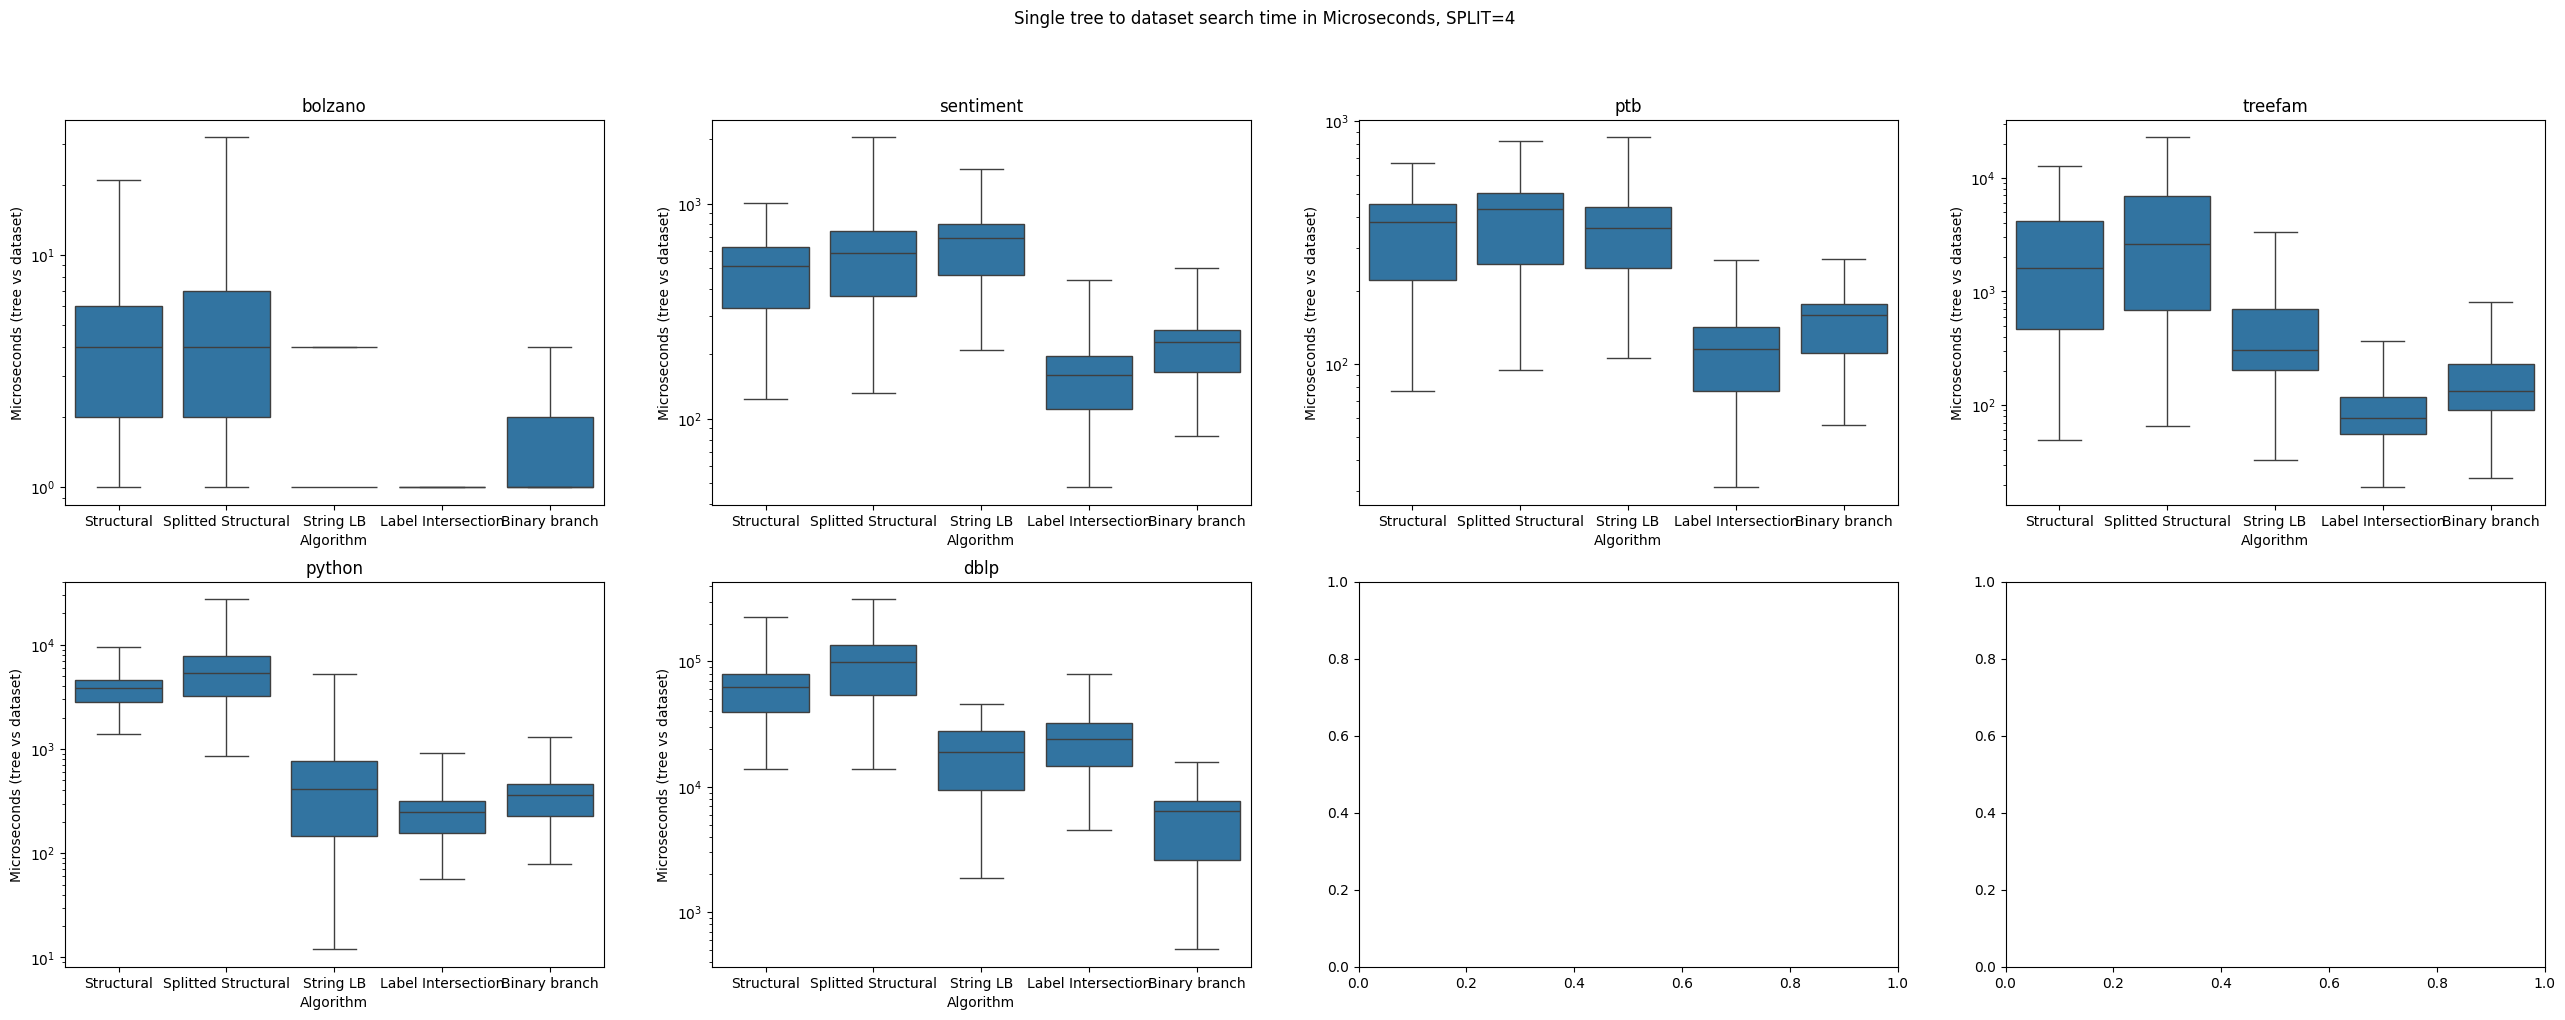

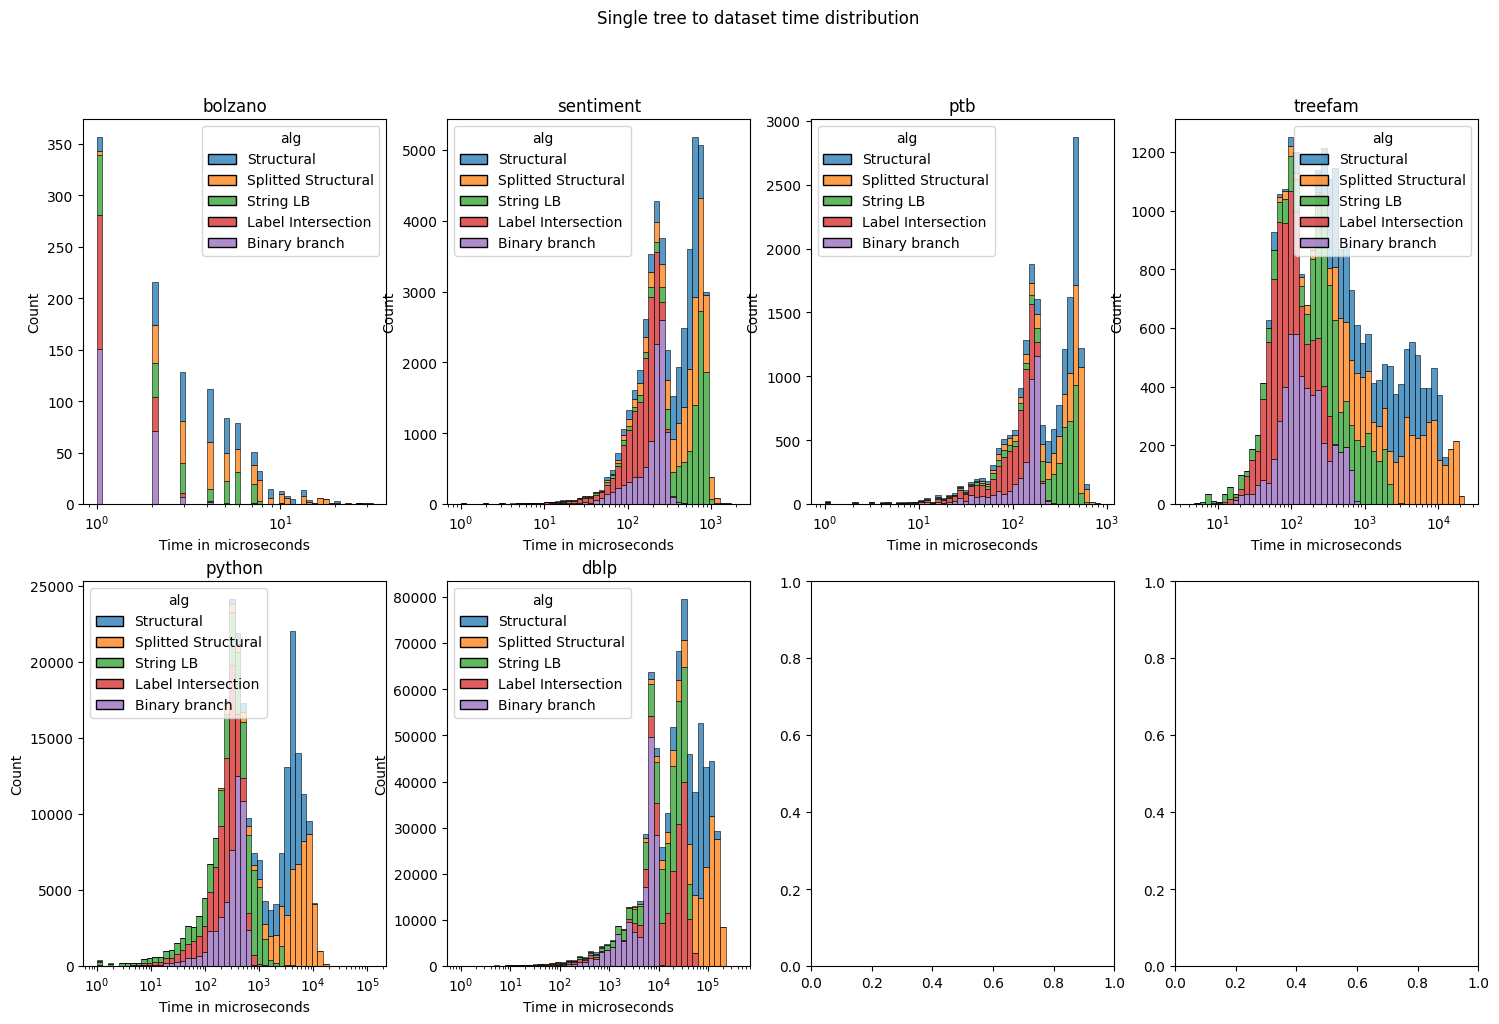

In [13]:
f, axes = plt.subplots(2, 4, figsize=(32, 11))
f.suptitle('Single tree to dataset search time in Microseconds, SPLIT=4')
f2, axes2 = plt.subplots(2, 4, figsize=(18, 11))
f2.suptitle('Single tree to dataset time distribution')
for i, (ds, x) in enumerate(tested_values):
    ax = int(i >= 4)
    ay = i % 4
    axes[ax][ay].set_title(ds)
    print('Printing ', ds)

    df = pd.DataFrame()
    for alg in dataframes[ds].keys():
        times = dataframes[ds][alg][0].copy()
        times['alg'] = ALGORITHMS[alg]
        df = pd.concat([df, times])
    bp = sns.boxplot(data=df, x='alg', y='time', log_scale=True, showfliers=False, ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds (tree vs dataset)')
    hp = sns.histplot(data=df, x="time", hue='alg', log_scale=True, multiple="stack", ax=axes2[ax][ay], bins=50)
    hp.set(xlabel='Time in microseconds', title=ds)

,Correct trees,Extra trees,Precision,Mean Selectivity,Algorithm,Dataset
0,57580,12127229,0.004726,0.0578807%,Binary branch,Dblp


Algorithm,Binary branch,Label Intersection,Splitted Structural,String LB,Structural
Dataset,,,,,
Bolzano,0.209097,0.575701,0.742169,0.793814,0.692135
Dblp,0.004726,0.929174,0.997816,0.999722,0.997004
Ptb,0.025842,0.508795,0.621446,0.868784,0.594252
Python,0.498965,0.921165,0.934040,0.951903,0.931018
Sentiment,0.029929,0.332827,0.421388,0.561078,0.379230
Treefam,0.162866,0.464744,0.571334,0.995826,0.568965


[Text(0.5, 1.0, 'Precision heatmap, SPLIT=4')]

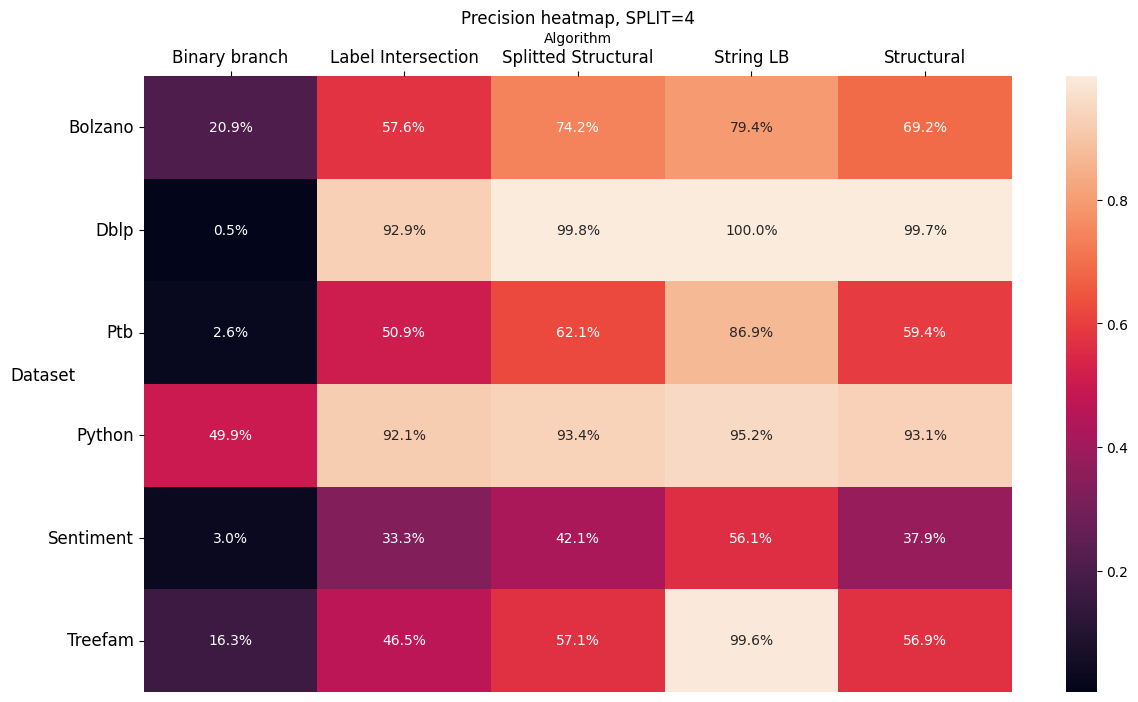

In [16]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds.capitalize()
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
display(summary)
pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Precision").fillna(0)
display(pivoted)
# sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(14, 8))
hp = sns.heatmap(pivoted, fmt='.1%', annot=True)
plt.yticks(rotation=0) 
plt.ylabel("Dataset", rotation=0, fontsize="large")
hp.xaxis.set_label_position('top')
plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = True, labeltop=True)
fig.savefig("resources/plots/precision-heatmap.svg", format='svg')
hp.set(title='Precision heatmap, SPLIT=4')


In [19]:
summary = dataframes[ds][alg][1].copy()
summary['Mean Selectivity'] = summary['Mean Selectivity'].str.strip('%')
summary

,Correct trees,Extra trees,Precision,Mean Selectivity
0,57580,12127229,0.004726,0.0578807


Algorithm,Binary branch,Label Intersection,Splitted Structural,String LB,Structural
Dataset,,,,,
Bolzano,0.018606,0.006328,0.004821,0.004492,0.005187
Dblp,0.000579,0.000003,0.000003,0.000003,0.000003
Ptb,0.028761,0.001326,0.001077,0.000766,0.001127
Python,0.004364,0.004048,0.004048,0.004048,0.004048
Sentiment,0.076645,0.005916,0.004606,0.003421,0.005142
Treefam,0.008683,0.002942,0.002370,0.001327,0.002381


[Text(0.5, 1.0, 'Selectivity heatmap, SPLIT=4')]

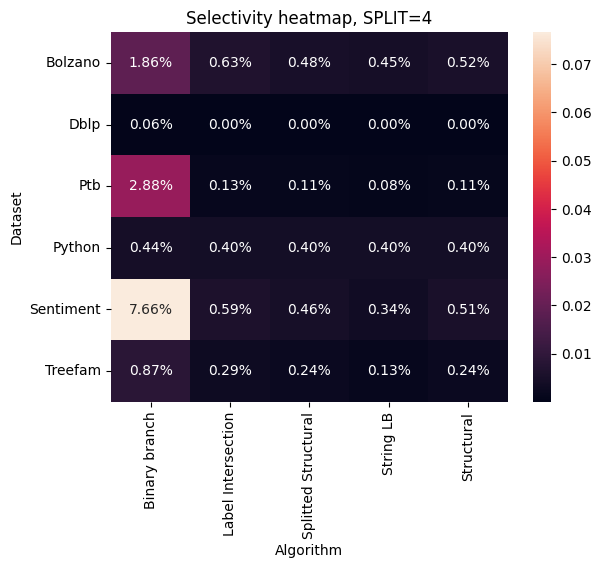

In [20]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds.capitalize()
        summary['Mean Selectivity'] = summary['Mean Selectivity'].str.strip('%')
        summary = summary.astype({'Mean Selectivity': 'float64'})
        summary['Mean Selectivity'] = summary['Mean Selectivity'] / 100
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Mean Selectivity").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True, fmt='.2%')
hp.set(title='Selectivity heatmap, SPLIT=4')

In [ ]:
dataframes = dict()
tested_values = [('sentiment', 5), ('sentiment', 15), ('sentiment', 20), ('sentiment', 10)]
dataframes['sentiment'] = dict()
for ds, t in tested_values:
    dataframes[ds][t] = load_dataset(ds, t)

,Correct trees,Extra trees,Precision,Algorithm,Threshold
0,173295,346429,0.333437,Label Intersection,10


Threshold,5,10,15,20
Algorithm,,,,
Bounded SED LB,0.755884,0.562106,0.531252,0.714993
Label Intersection,0.429923,0.333437,0.311100,0.421020
Splitted Structural,0.584731,0.421961,0.393487,0.518558
Structural,0.516448,0.380023,0.367358,0.483257


[Text(0.5, 1.0, 'Sentiment Precision heatmap, SPLIT=4')]

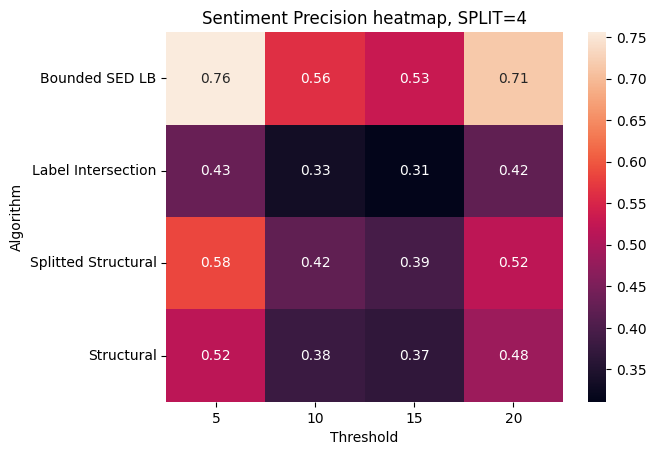

In [59]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds][x].keys():
        summary = dataframes[ds][x][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Threshold'] = x
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
display(summary)
pivoted = df.pivot(index="Algorithm", columns="Threshold", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Sentiment Precision heatmap, SPLIT=4')

In [6]:
selectivities = [('sentiment', 0.0746, 5), ('sentiment', 0.859, 10), ('sentiment', 3.04574, 15), ('sentiment', 8.496, 20)]
pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])

,Dataset,Mean query selectivity %,Threshold
0,sentiment,0.07460,5
1,sentiment,0.85900,10
2,sentiment,3.04574,15
3,sentiment,8.49600,20


In [76]:
df = pd.read_csv('./python-Structural-times-us.txt', header=None, names=["LB time"])

In [77]:
df['LB time'].sum() / 1000 / 1000

168.53804300000002

In [78]:
df = pd.read_csv('./resources/results/python/15/python-Structural-times-us.txt', header=None, names=["LB time"])

In [79]:
df['LB time'].sum() / 1000 / 1000

186.34054999999998

In [102]:
from os.path import join
df = pd.DataFrame()
cdf = pd.DataFrame()
for ds in datasets:
    times_path = join('resources/puser-results', ds, 'times.txt')
    t = pd.read_csv(times_path, delimiter=';')
    t = t.rename(columns=ALGORITHMS)
    df = pd.concat([df, t.head(1)])
    
    cdf = pd.concat([cdf, t.iloc[[1]]])
df = df.set_index('dataset')
cdf = cdf.set_index('dataset')
display(df)
# display(df.transpose())
display(cdf)

,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural
dataset,,,,,,
dblp,395,16655,2110,20037,1108,20806
ptb,11,52,55,151,24,173
python,37,338,302,246,81,946
sentiment,7,9,13,36,16,17
swissprot,102,9016,970,16821,648,47854
treefam,33,19,250,194,148,76


,Lbl-Int Index,Lbl-Int,Sed Index,Sed,Structural Index,Structural
dataset,,,,,,
dblp,136180,136180,70641,70641,71750,71750
ptb,571,372,245,245,529,322
python,72288,72288,72288,72288,72288,72288
sentiment,222,222,135,135,153,153
swissprot,6784,6784,4666,4666,6652,6652
treefam,14075,14075,8055,8055,8268,8268


In [68]:
(df.transpose())['dblp']

Lbl-Int Index         395
Lbl-Int             16655
Sed Index            2110
Sed                 20037
Structural Index     1108
Structural          20806
Name: dblp, dtype: int64

Printing  dblp
Printing  ptb
Printing  python
Printing  sentiment
Printing  swissprot
Printing  treefam


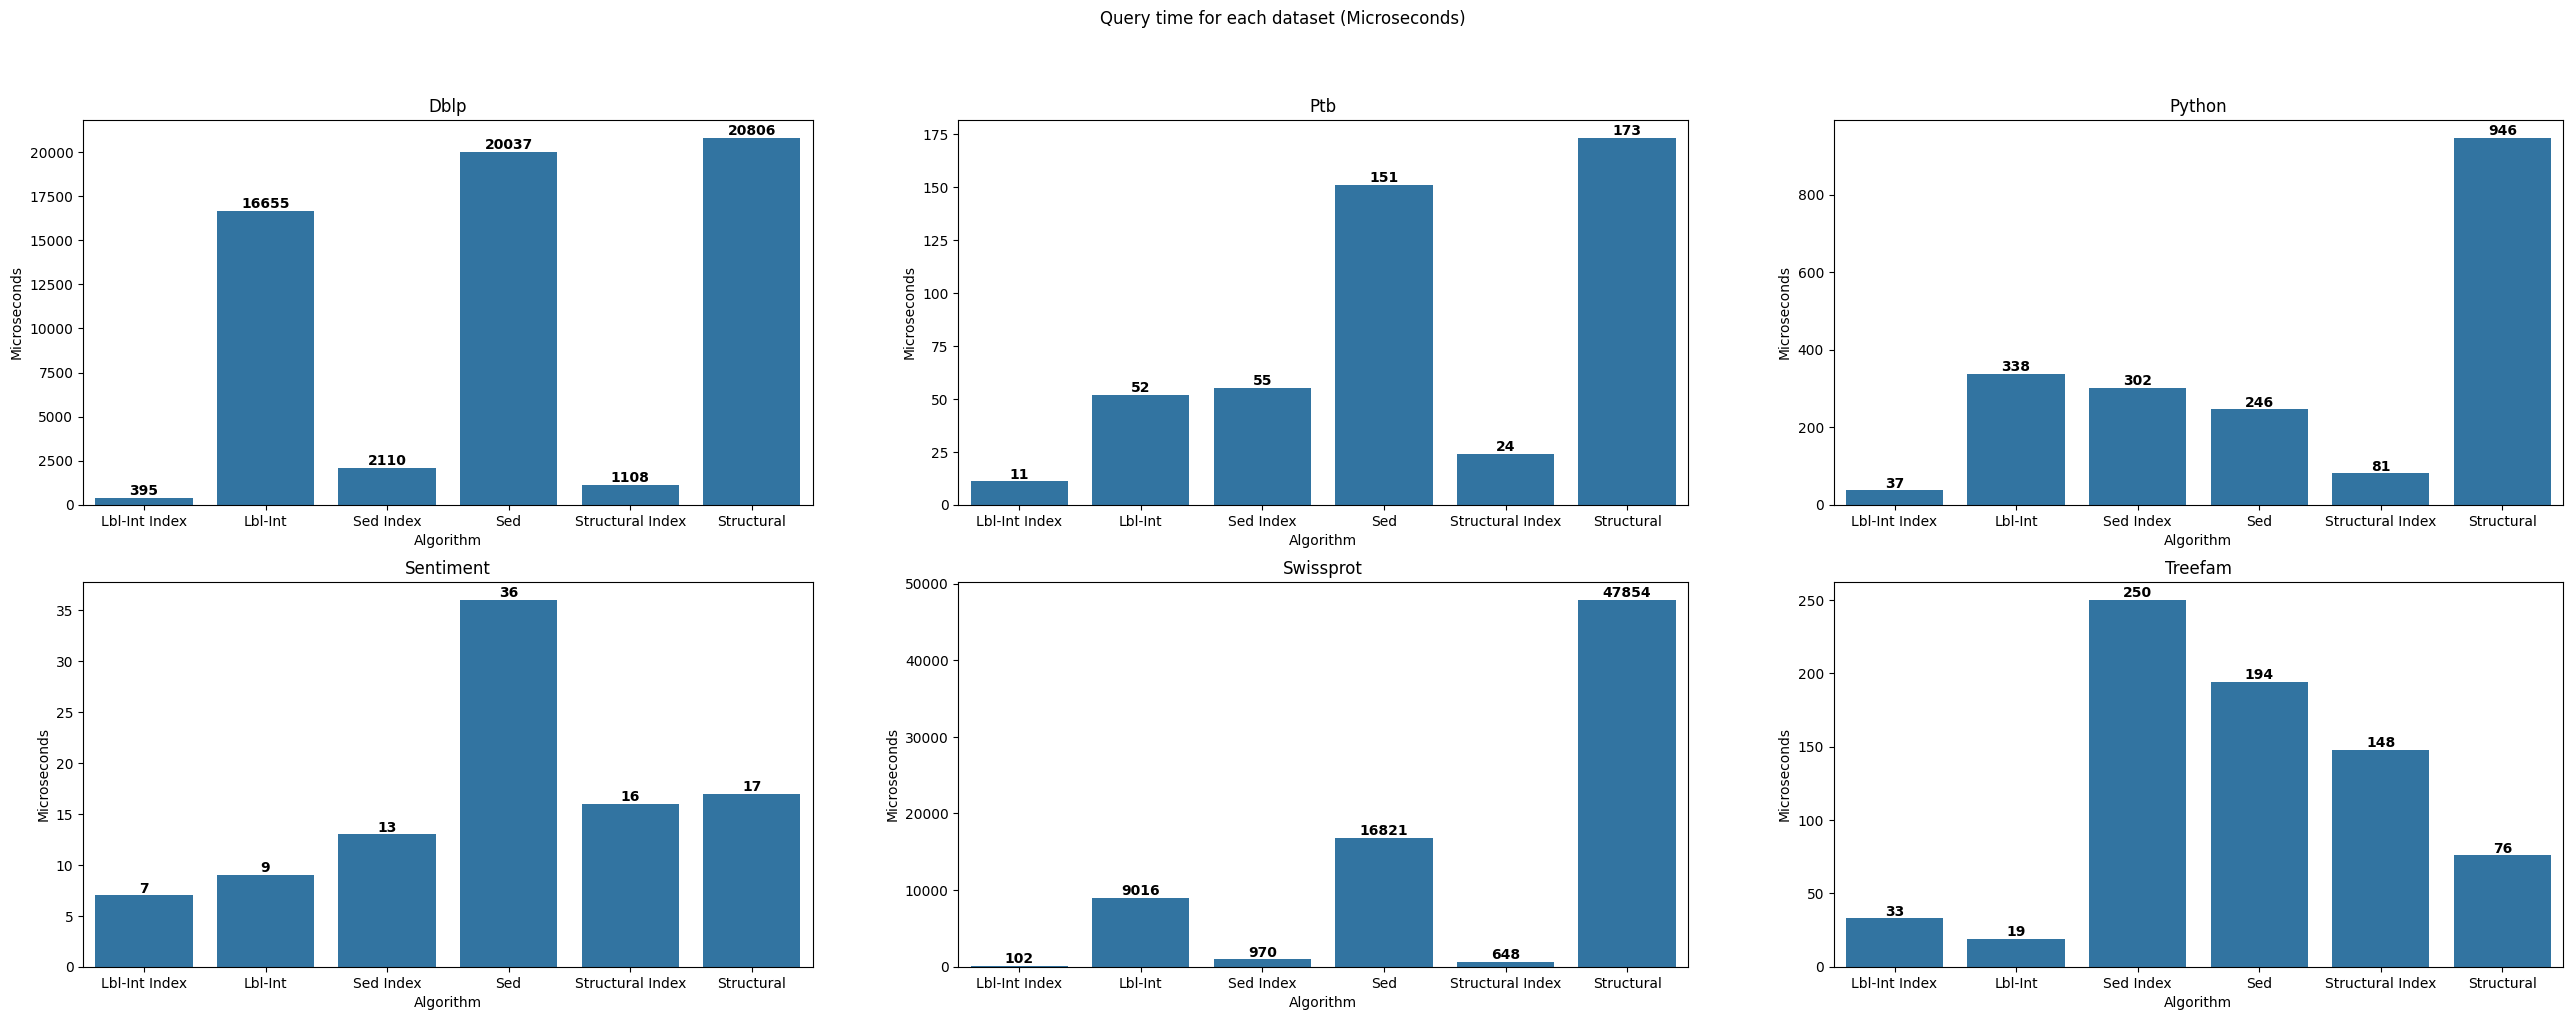

In [91]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
tdf = df.transpose()
f.suptitle('Query time for each dataset (Microseconds)')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(tdf[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(tdf[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')


Printing  dblp
Printing  ptb
Printing  python
Printing  sentiment
Printing  swissprot
Printing  treefam


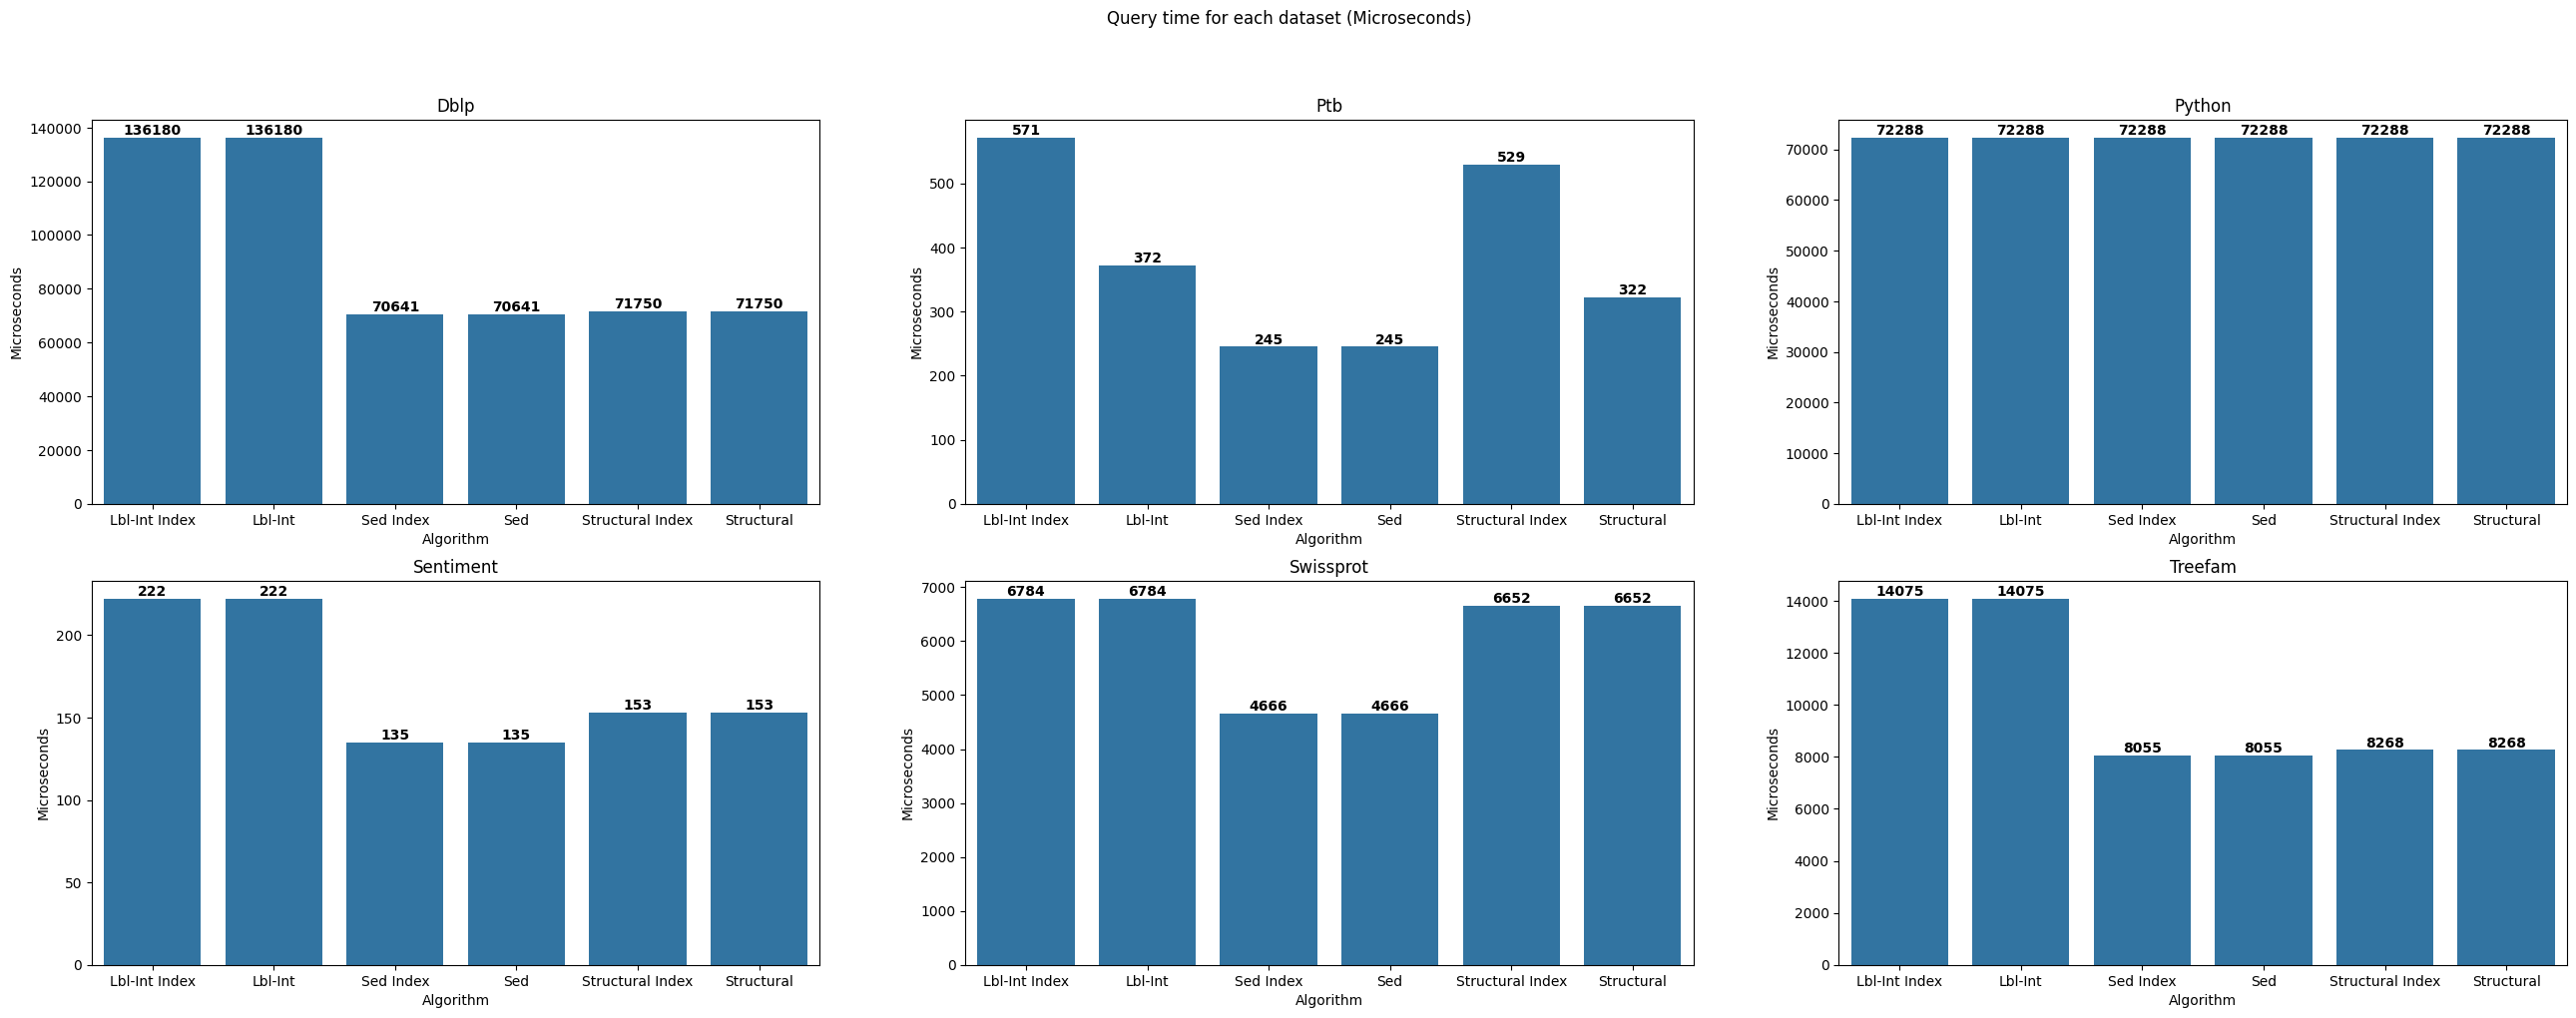

In [103]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
tdf = cdf.transpose()
f.suptitle('Number of candidates')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(tdf[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Candidates')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(tdf[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')

In [125]:
jdf = df.join(cdf, on='dataset', rsuffix='-candidates')

for alg in ALGORITHMS.values():
    if alg not in jdf:
        continue
    
    jdf[f'{alg}-ratio'] = round(jdf[f'{alg}'] / jdf[f'{alg}-candidates'], 4)

display(jdf.iloc[:, 12:])

,Structural-ratio,Sed-ratio,Lbl-Int-ratio,Sed Index-ratio,Lbl-Int Index-ratio,Structural Index-ratio
dataset,,,,,,
dblp,0.290,0.284,0.122,0.030,2.900e-03,0.015
ptb,0.537,0.616,0.140,0.225,1.930e-02,0.045
python,0.013,0.003,0.005,0.004,5.000e-04,0.001
sentiment,0.111,0.267,0.041,0.096,3.150e-02,0.105
swissprot,7.194,3.605,1.329,0.208,1.500e-02,0.097
treefam,0.009,0.024,0.001,0.031,2.300e-03,0.018


Printing  dblp
Printing  ptb
Printing  python
Printing  sentiment
Printing  swissprot
Printing  treefam


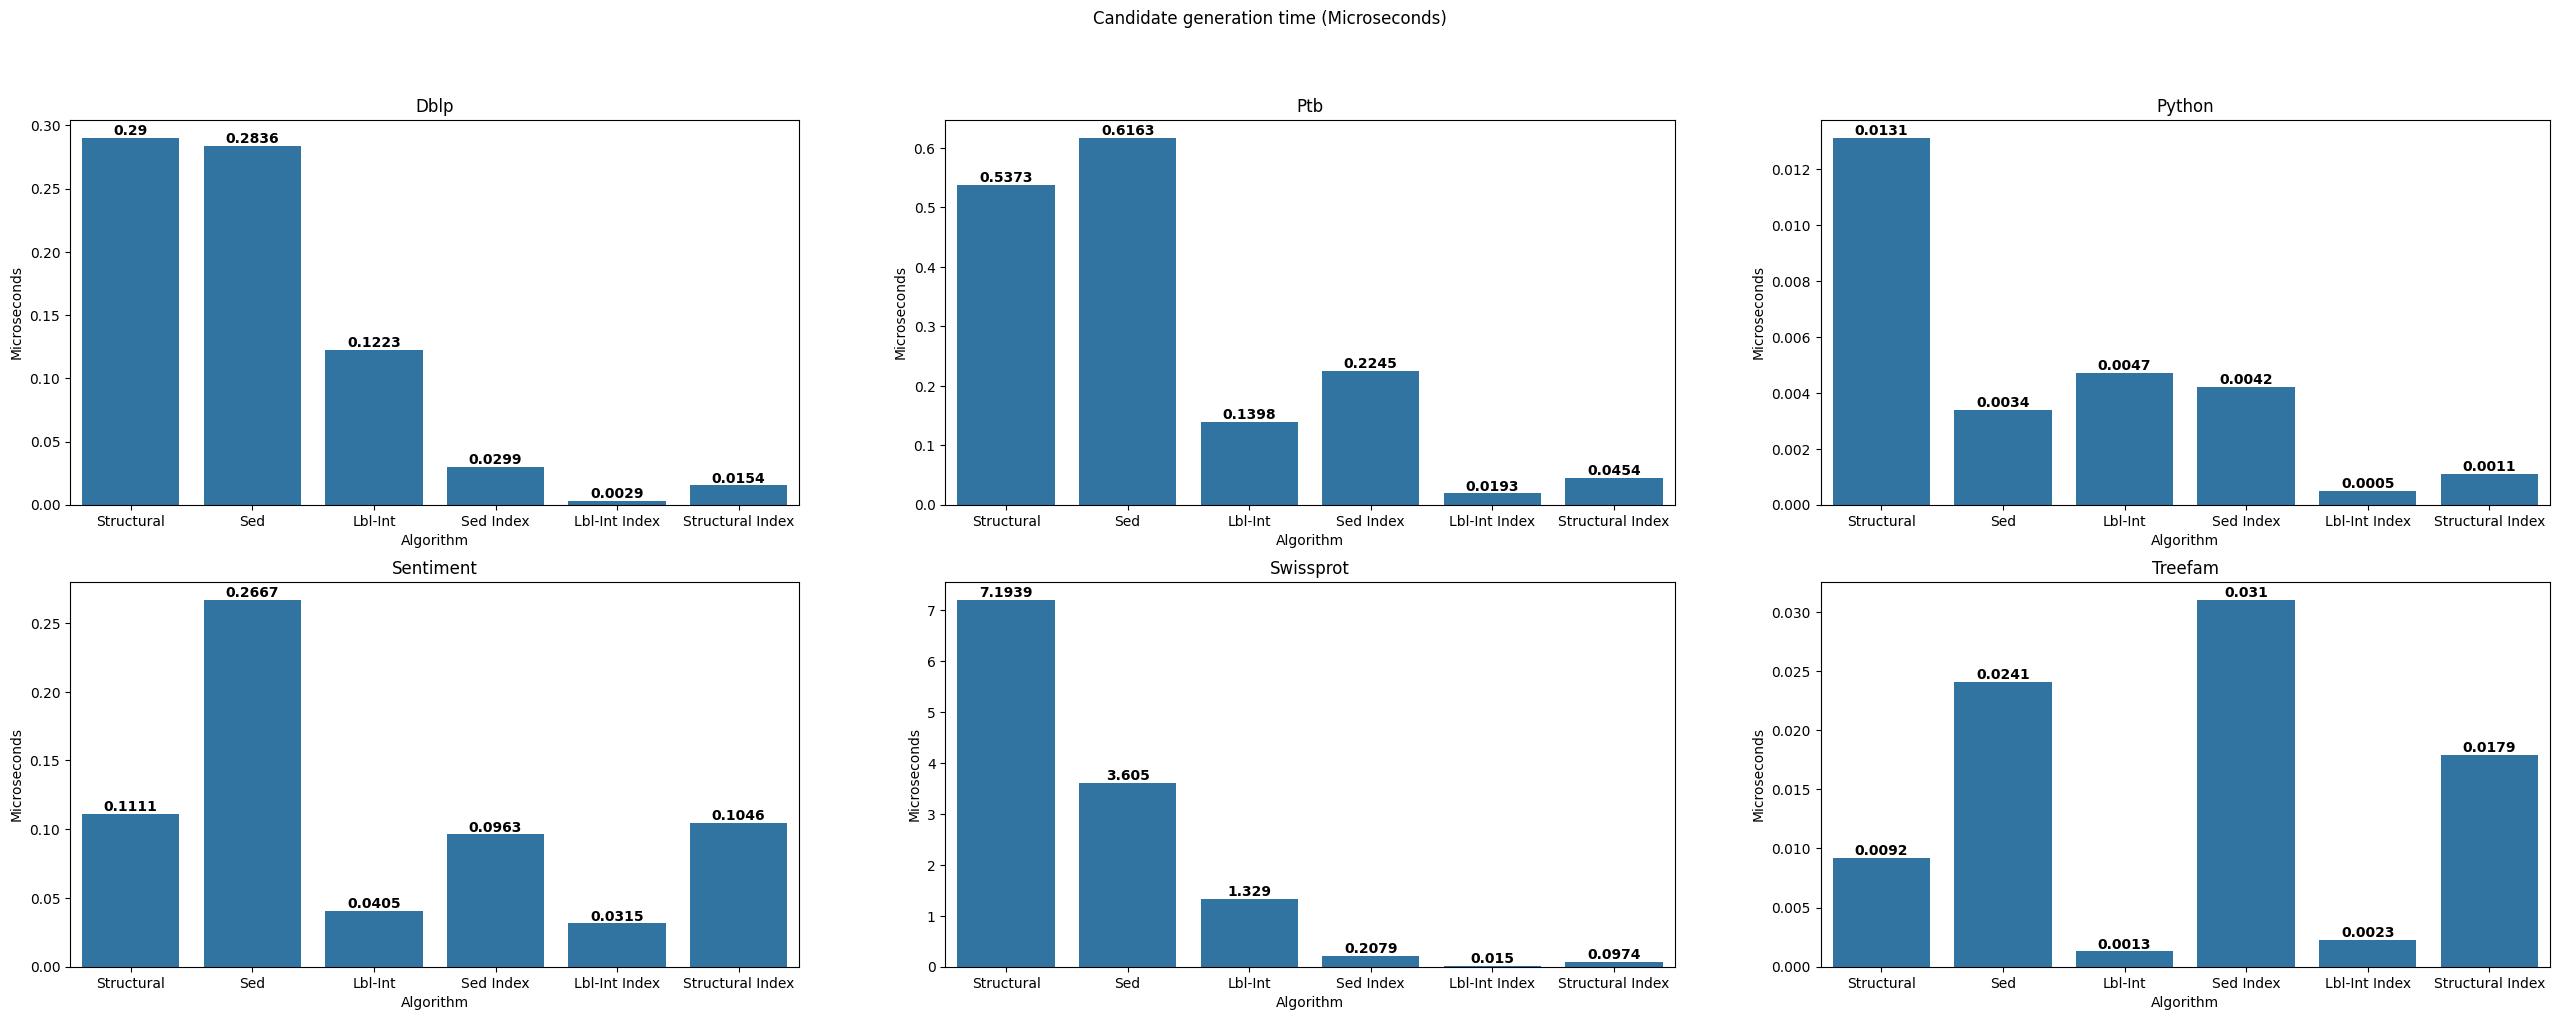

In [132]:
f, axes = plt.subplots(2, 3, figsize=(32, 11))
jdf = jdf.iloc[:, 12:].rename(mapper=lambda x: x.replace('-ratio', ''), axis=1)
tdf = jdf.transpose()
f.suptitle('Candidate generation time (Microseconds)')

# Custom color palette

for i, ds in enumerate(datasets):
    ax = int(i >= 3)
    ay = i % 3
    axes[ax][ay].set_title(ds.capitalize())
    print('Printing ', ds)
    bp = sns.barplot(tdf[ds], ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds')
    bp.set_title(ds.capitalize())

    # Add value annotations on top of each bar
    for i, v in enumerate(tdf[ds]):
        axes[ax][ay].text(i, v, str(v), 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')

In [87]:
tdf['dblp']

Lbl-Int Index         395
Lbl-Int             16655
Sed Index            2110
Sed                 20037
Structural Index     1108
Structural          20806
Name: dblp, dtype: int64

<Axes: ylabel='python'>

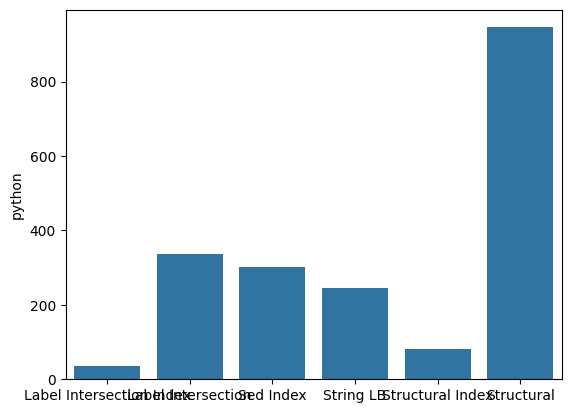

In [57]:
sns.barplot(tdf['python'])

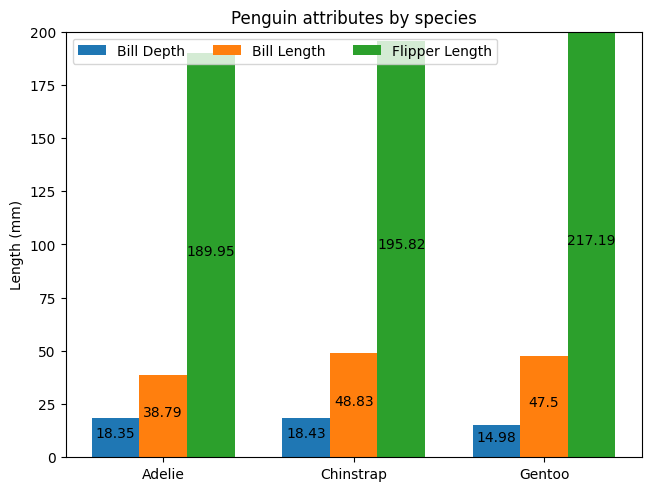

In [52]:
import matplotlib.pyplot as plt
import numpy as np

species = ("Adelie", "Chinstrap", "Gentoo")
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98),
    'Bill Length': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, label_type='center')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 200, auto=None)

plt.show()

# Search results

,InMemory,Postgres
Label intersection,63.0,5608.513
SED,252.0,12462.401
Structural,346.0,52983.795


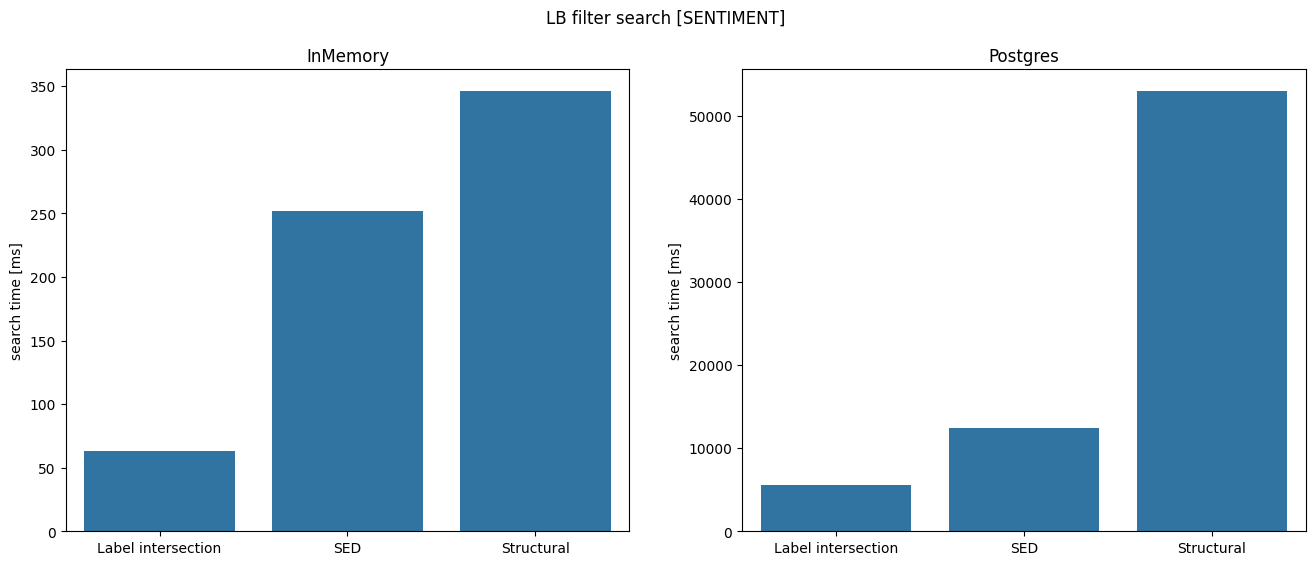

In [34]:
f, axes = plt.subplots(1, 2, figsize=(16, 6))
f.suptitle('LB filter search [SENTIMENT]')

methods = ("Label intersection", "SED", "Structural")
measure_envs = {
    'InMemory': (63.0, 252.0, 346.0),
    'Postgres': (5608.513, 12462.401, 52983.795),
}

df = pd.DataFrame(data={'InMemory': [63.0, 252.0, 346.0], 'Postgres': [5608.513, 12462.401, 52983.795]}, index=["Label intersection", "SED", "Structural"])
display(df)

mem = sns.barplot(data=df['InMemory'], ax=axes[0])
post = sns.barplot(data=df['Postgres'], ax=axes[1])
axes[0].set_title('InMemory')
axes[1].set_title('Postgres')

axes[0].set_ylabel('search time [ms]')
axes[1].set_ylabel('search time [ms]')

plt.show()